<a href="https://colab.research.google.com/github/sergioar3143/AprendizajeProfundo/blob/main/Tarea2_Redes_convolucionales_y_transferencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importar bibliotecas y descargar el dataset de FairFace

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.signal import correlate2d, convolve2d
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import PIL
import copy
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
from sklearn.model_selection import train_test_split
import torchvision as tv

# Por reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

!gdown --id 1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
!gdown --id 1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH
!gdown --id 1wOdja-ezstMEp81tX1a-EYkFebev4h7D
!rm -r "/content/FairFace"
!unzip "/content/fairface-img-margin025-trainval.zip" -d "/content/FairFace"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/FairFace/val/5370.jpg  
  inflating: /content/FairFace/val/5596.jpg  
  inflating: /content/FairFace/val/5875.jpg  
  inflating: /content/FairFace/val/5878.jpg  
  inflating: /content/FairFace/val/5879.jpg  
  inflating: /content/FairFace/val/5883.jpg  
  inflating: /content/FairFace/val/6126.jpg  
  inflating: /content/FairFace/val/6132.jpg  
  inflating: /content/FairFace/val/6144.jpg  
  inflating: /content/FairFace/val/6150.jpg  
  inflating: /content/FairFace/val/6340.jpg  
  inflating: /content/FairFace/val/7190.jpg  
  inflating: /content/FairFace/val/7734.jpg  
  inflating: /content/FairFace/val/7747.jpg  
  inflating: /content/FairFace/val/7872.jpg  
  inflating: /content/FairFace/val/7940.jpg  
  inflating: /content/FairFace/val/8065.jpg  
  inflating: /content/FairFace/val/8069.jpg  
  inflating: /content/FairFace/val/8125.jpg  
  inflating: /content/FairFace/val/8202.jpg  
  inflating: /conte

#Operación de convolución

Se carga el conjunto de datos y se normaliza para que los pixeles se encuentren en el rango de (0-1).


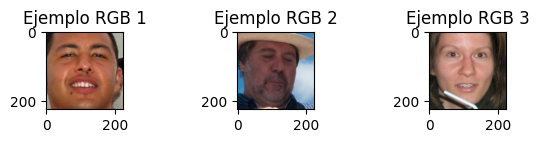

In [19]:
imagen0 = cv2.imread("/content/FairFace/val/10897.jpg")
imagen0 = cv2.cvtColor(imagen0,cv2.COLOR_BGR2RGB)
imagen0 = imagen0 / imagen0.max()

imagen1 = cv2.imread("/content/FairFace/val/8074.jpg")
imagen1 = cv2.cvtColor(imagen1,cv2.COLOR_BGR2RGB)
imagen1 = imagen1 / imagen1.max()

imagen2 = cv2.imread("/content/FairFace/val/9821.jpg")
imagen2 = cv2.cvtColor(imagen2,cv2.COLOR_BGR2RGB)
imagen2 = imagen2 / imagen2.max()

fig, axs = plt.subplots(1, 3, figsize=(7, 1))
axs[0].imshow(imagen0, cmap = 'gray')
axs[0].set_title('Ejemplo RGB 1')
axs[1].imshow(imagen1, cmap = 'gray')
axs[1].set_title('Ejemplo RGB 2')
axs[2].imshow(imagen2, cmap = 'gray')
axs[2].set_title('Ejemplo RGB 3')
plt.show()

Correlación cruzada y convolución

Ahora consideremos las operación de convolución entre una imagen $I$ y un filtro $W$, la cual está definida por

$$
A_{i,j} = (\mathbf{I} * \mathbf{W})_{i,j} = \sum_m \sum_n I_{m, n} W_{i - m, j - n}
$$

La convolución es commutativa, por lo tanto

$$
A_{i,j} = (\mathbf{W} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i - m, j - n} W_{m,n}
$$

En lugar de la convolución, frecuentemente se ocupa la operación de correlación cruzada para llevar a cabo las capas convolucionales. Esta operación es similar a la convolución pero sin voltear el filtro (por lo que pierde la propiedad de conmutatividad) y está dada por

$$
A_{i,j} = (\mathbf{W} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i + m, j + n} W_{m,n}
$$

El resultado de estas operaciones es el mapa de activaciones $A(i,j)$.

In [48]:
def conv2d(I, W, b, stride = 1):
  h_s = int(np.floor((I.shape[0] - W.shape[0]) / stride)) + 1
  w_s = int(np.floor((I.shape[1] - W.shape[1]) / stride)) + 1
  k=I.shape[2]
  a = np.zeros((h_s, w_s, k))
  for channel in range(k):
    for i in range(h_s):
      for j in range(w_s):
        I_m = I[i * stride:i * stride + W.shape[0], j * stride:j * stride + W.shape[1], channel]
        a[i, j,channel] = (I_m * W[:,:,channel]).sum() + b
  return a

Filtro

Definamos un tensor que represente 3 filtros de $3 \times 3$ que detecte bordes en cierta orientación:

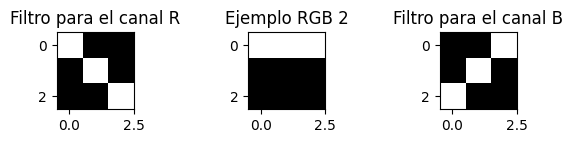

In [73]:
import math
filter1 = np.zeros((3,3,3))
np.fill_diagonal(filter1[:,:,0], np.array([1, 1, 1]))
filter1[:,:,1]=np.asarray([(1,1,1),(0,0,0),(0,0,0)])
filter1[:,:,2]=filter1[:,:,0][::-1]
filter1=filter1/math.sqrt(3) ##Normalizar filtros para que el resultado se encuentre entre 0 y 1

fig, axs = plt.subplots(1, 3, figsize=(7, 1))
axs[0].imshow(filter1[:,:,0] * 0.5 + 0.5, cmap = 'gray')
axs[0].set_title('Filtro para el canal R')
axs[1].imshow(filter1[:,:,1] * 0.5 + 0.5, cmap = 'gray')
axs[1].set_title('Ejemplo RGB 2')
axs[2].imshow(filter1[:,:,2] * 0.5 + 0.5, cmap = 'gray')
axs[2].set_title('Filtro para el canal B')
plt.show()

También se define la función

In [74]:
sigmoid = lambda z: 1. / (1. + np.exp(-z))

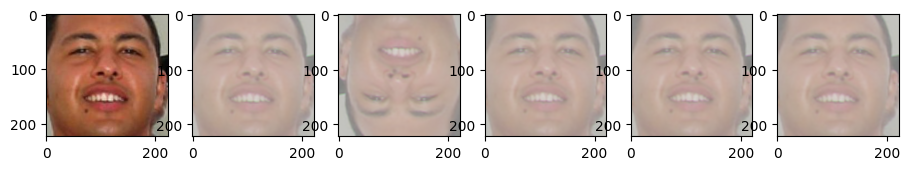

In [75]:
ccorr=np.zeros((222, 222, 3))
for ch in range(ccorr.shape[2]):
  ccorr[:,:,ch] =sigmoid(correlate2d(imagen0[:,:,ch], filter1[:,:,ch], mode = 'valid'))

ccorr2=np.zeros((222, 222, 3))
for ch in range(ccorr2.shape[2]):
  ccorr2[:,:,ch] = sigmoid(correlate2d(filter1[:,:,ch], imagen0[:,:,ch], mode = 'valid'))

conv=np.zeros((222, 222, 3))
for ch in range(conv.shape[2]):
  conv[:,:,ch] = sigmoid(convolve2d(imagen0[:,:,ch], filter1[:,:,ch], mode = 'valid'))

conv2=np.zeros((222, 222, 3))
for ch in range(conv.shape[2]):
  conv2[:,:,ch] = sigmoid(convolve2d(filter1[:,:,ch], imagen0[:,:,ch], mode = 'valid'))

a = sigmoid(conv2d(imagen0, filter1, 0))

fig, axs = plt.subplots(1, 6, figsize=(11, 3))
axs[0].imshow(imagen0)
axs[1].imshow(ccorr)
axs[2].imshow(ccorr2)
axs[3].imshow(conv)
axs[4].imshow(conv2)
axs[5].imshow(a)
plt.show()

#Clasificación de rostros por grupo etario

In [17]:
df_train = pd.read_csv('/content/fairface_label_train.csv')
df_val = pd.read_csv('/content/fairface_label_val.csv')
df_train.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [18]:
clase=list(np.unique(df_train['age']))
clase_a_ind = {c:i for i,c in enumerate(clase)}
ind_a_clase = {i:c for i,c in enumerate(clase)}

for i in clase:
  print(f'A la clase de {i} años le corresponde el indice {clase_a_ind[i]}')

A la clase de 0-2 años le corresponde el indice 0
A la clase de 10-19 años le corresponde el indice 1
A la clase de 20-29 años le corresponde el indice 2
A la clase de 3-9 años le corresponde el indice 3
A la clase de 30-39 años le corresponde el indice 4
A la clase de 40-49 años le corresponde el indice 5
A la clase de 50-59 años le corresponde el indice 6
A la clase de 60-69 años le corresponde el indice 7
A la clase de more than 70 años le corresponde el indice 8


In [19]:
df_train['ind']=0
df_val['ind']=0
for i in clase:
  idx=df_train.loc[:,'age']==i
  df_train.loc[idx, 'ind']=clase_a_ind[i]

  idx=df_val.loc[:,'age']==i
  df_val.loc[idx, 'ind']=clase_a_ind[i]

In [20]:
X_train, X_val, y_train, y_val = train_test_split(df_train['file'], df_train['ind'], test_size=0.3, random_state=42, shuffle=True, stratify=df_train['ind'])
X_test , y_test = df_val['file'], df_val['ind']

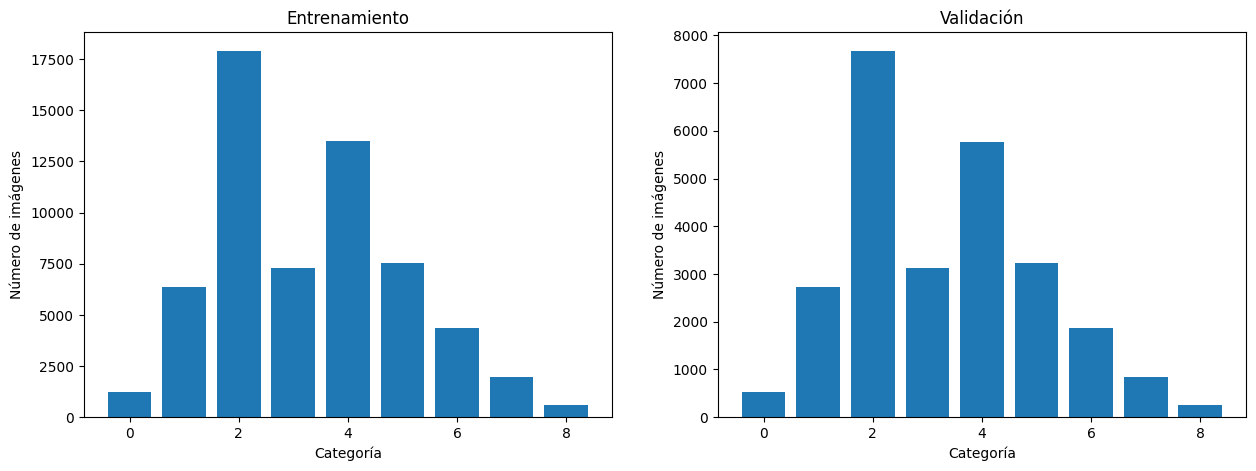

In [21]:
idx_ent, cuentas_ent = np.unique(y_train, return_counts=True)
idx_val, cuentas_val = np.unique(y_val, return_counts=True)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].bar(x=idx_ent, height=cuentas_ent)
axs[0].set_title('Entrenamiento')
axs[0].set_xlabel('Categoría')
axs[0].set_ylabel('Número de imágenes')

axs[1].bar(x=idx_val, height=cuentas_val)
axs[1].set_title('Validación')
axs[1].set_xlabel('Categoría')
axs[1].set_ylabel('Número de imágenes')

plt.show()

In [22]:
class Face_age(Dataset):
  def __init__(self, x, y, raiz, transform = None):
    self.x = x
    self.y = y
    self.raiz = raiz
    self.transform = transform
    self.disp = 'cuda' if torch.cuda.is_available() else 'cpu'

  def __getitem__(self, idx):
    img = PIL.Image.open(self.raiz+"/"+self.x.iloc[idx])
    cat = self.y.iloc[idx]
    cat = nn.functional.one_hot(torch.tensor(cat), num_classes=9)
    cat = cat.to(dtype=torch.float32, device=self.disp)

    if self.transform:
      img = self.transform(img)
      img = img.to(self.disp)

    return img, cat

  def __len__(self):
    return len(self.x)


In [23]:
dir_raiz = 'FairFace'
ds_ent = Face_age(X_train, y_train, dir_raiz)
ds_ent.disp="cpu"
print(ds_ent.disp)

cpu


In [24]:
it_ent = iter(ds_ent)
img_ent, cat_ent = next(it_ent)
img_ent, cat_ent = next(it_ent)
img_ent, cat_ent = next(it_ent)

cat_ent=cat_ent.cpu().numpy()
cat_ent=np.argmax(cat_ent)

print(f'Imagen = {img_ent}, Categoría = {cat_ent}')

Imagen = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7B906860B0A0>, Categoría = 4


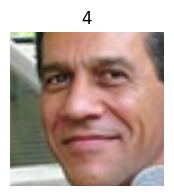

(224, 224)


In [25]:
plt.figure(figsize = (2,2))
plt.imshow(img_ent)
plt.title(cat_ent)
plt.axis('off')
plt.show()

print(img_ent.size)

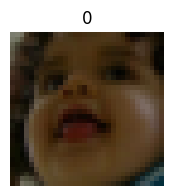

In [26]:
IMG_SIZE = 32

tsfm = transforms.Compose([
    transforms.Resize(IMG_SIZE,antialias = True),
    transforms.ToTensor(),
    #transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tsfm2 = transforms.Compose([transforms.RandomResizedCrop(IMG_SIZE, scale = (0.85, 1.0),antialias = True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(),
                            #transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dir_raiz = 'FairFace'
#ds_ent = Face_age(X_train, y_train, dir_raiz, transform=tsfm)
ds_ent = Face_age(X_train, y_train, dir_raiz, transform=tsfm2)
it_ent = iter(ds_ent)
img_ent, cat_ent = next(it_ent)
img_ent, cat_ent = next(it_ent)

cat_ent=cat_ent.cpu().numpy()
cat_ent=np.argmax(cat_ent)

plt.figure(figsize = (2,2))
plt.imshow(img_ent.permute(1, 2, 0).cpu().numpy())
plt.title(cat_ent)
plt.axis('off')
plt.show()

In [27]:
dir_raiz = 'FairFace'
trn_ds = Face_age(X_train, y_train, dir_raiz, transform=tsfm2)
val_ds = Face_age(X_val, y_val, dir_raiz, transform=tsfm)

trn_dl = DataLoader(trn_ds, batch_size=128, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False)

In [28]:
def guarda_ckpt(ckptpath, modelo, epoca, opt):
  estado_modelo = {'epoch': epoca,
                   'model_state_dict': modelo.state_dict(),
                   'optimizer_state_dict': opt.state_dict()}
  torch.save(estado_modelo, ckptpath)

In [29]:
def registra_info_tboard(writer, epoca, hist):
  for (m,v) in hist.items():
    writer.add_scalar(m, v[epoca], epoca)

In [30]:
def exactitud(y_hat, y):
  cmp = y_hat.argmax(dim=-1) == y.argmax(dim=-1)
  #cmp = y_hat.argmax(dim=-1) == y
  aciertos = torch.count_nonzero(cmp)
  return aciertos / cmp.shape[0]

In [31]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        out_channels1, out_channels2 = out_channels

        if in_channels != out_channels2:
          self.conv1x1 = nn.Conv2d(in_channels, out_channels2, 1)
        else:
          self.conv1x1 = None

        # [N, I, H, W] => [N, O2, H, W]
        self.cnn_block = nn.Sequential(
            # conv1
            # [N, I, H, W] => [N, O1, H, W]
            ##Depthwise conv
            nn.Conv2d(in_channels, out_channels2, kernel_size=7, groups=in_channels, padding = 'same'),
            # [N, O1, H, W]
            nn.GroupNorm(1, out_channels2),
            # [N, O1, H, W]
            nn.Conv2d(out_channels2, out_channels1 ,kernel_size=1),
            nn.GELU(),
            # conv2
            # [N, O1, H, W] => [N, O2, H, W]
            nn.Conv2d(out_channels1,out_channels2, kernel_size=1, padding = 'same'),
            # [N, O2, H, W]
        )

    def forward(self, x):
        # [N, I, H, W] => [N, O2, H, W]
        x1 = self.cnn_block(x)
        # [N, O2, H, W]
        if self.conv1x1:
          x = self.conv1x1(x)
        x = x1 + x
        return x

In [32]:
class MicroConv(nn.Module):

    def __init__(self):
        super(MicroConv, self).__init__()
        self.num_feats = 384 * 4 * 4
        # [N, 3, 32, 32] => [N, 96, 16, 16]
        self.cnn = nn.Sequential(
            # [N, 3, 32, 32] => [N, 96, 32, 32]
            ConvBlock(in_channels=3, out_channels=(384,96)),
            # [N, 96, 32, 32] => [N, 96, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 96, 16, 16] => [N, 192, 16, 16]
            ConvBlock(in_channels=96, out_channels=(768,192)),
            # [N, 192, 16, 16] => [N, 192, 8, 8]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 192, 8, 8] => [N, 384, 8, 8]
            ConvBlock(in_channels=192, out_channels=(1536,384)),
            # [N, 384, 8, 8] => [N, 384, 4, 4]
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # [N, 3, 32, 32] => [N, 3x32x32]
        # [N, 3x32x32] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 9)

    def forward(self, x):
        # [N, 3, 64, 64] => [N, 3, 32, 32]
        x = self.cnn(x)
        # [N, 3, 32, 32] => [N, 3x32x32]
        x = torch.flatten(x,1)
        # [N, 3x32x32] => [N, 1]
        x = self.cls(x)
        return nn.functional.softmax(x,dim=1)

In [33]:
class DeepConv(nn.Module):

    def __init__(self):
        super(DeepConv, self).__init__()
        self.num_feats = 768
        # [N, 3, 32, 32] => [N, 96, 16, 16]
        self.cnn = nn.Sequential(
            # [N, 3, 32, 32] => [N, 96, 32, 32]
            ConvBlock(in_channels=3, out_channels=(384,96)),
            # [N, 96, 32, 32] => [N, 96, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 96, 16, 16] => [N, 192, 16, 16]
            ConvBlock(in_channels=96, out_channels=(768,192)),
            # [N, 192, 16, 16] => [N, 192, 8, 8]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 192, 8, 8] => [N, 384, 8, 8]
            ConvBlock(in_channels=192, out_channels=(1536,384)),
            # [N, 384, 8, 8] => [N, 384, 4, 4]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 384, 4, 4] => [N, 768, 4, 4]
            ConvBlock(in_channels=384, out_channels=(3072,768))
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        # [N, 3, 32, 32] => [N, 3x32x32]
        # [N, 3x32x32] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 9)

    def forward(self, x):
        # [N, 3, 64, 64] => [N, 3, 32, 32]
        x = self.cnn(x)
        x = self.gap(x)
        # [N, 3, 32, 32] => [N, 3x32x32]
        x = torch.flatten(x,1)
        # [N, 3x32x32] => [N, 1]
        x = self.cls(x)
        return nn.functional.softmax(x,dim=1)

In [34]:
model = MicroConv()
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(y)

it_ent = iter(trn_ds)
img_ent, cat_ent = next(it_ent)
print(cat_ent)

tensor([[0.1339, 0.1233, 0.0915, 0.1360, 0.0834, 0.1250, 0.0858, 0.1066, 0.1145]],
       grad_fn=<SoftmaxBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')


In [35]:
def paso_ent(modelo,
             fp,
             metrica,
             opt,
             X,
             y):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                    # a actualizaren en cero
  y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
  perdida = fp(y_hat, y) # se calcula la pérdida
  perdida.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo

  with torch.no_grad():
    perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
    metricas_paso = metrica(y_hat, y)

  return perdida_paso, metricas_paso

In [36]:
def entrena(modelo,
            fp,
            metrica,
            opt,
            entdl,
            valdl,
            disp,
            ckptpath,
            n_epocas = 10,
            tbdir = 'runs/'):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {'perdida_ent':np.zeros(n_epocas),
          'perdida_val': np.zeros(n_epocas),
          metrica.__name__ + '_ent': np.zeros(n_epocas),
          metrica.__name__ + '_val': np.zeros(n_epocas)}

  tbwriter = SummaryWriter(tbdir)
  perdida_min = torch.inf
  mejor_modelo = copy.deepcopy(modelo)

  for e in range(n_epocas):
    # bucle de entrenamiento
    modelo.train()
    for p, (Xlote,ylote) in enumerate(entdl):
      #print(Xlote.shape)
      Xlote = Xlote.to(disp)
      ylote = ylote.to(disp)

      perdida_paso, metrica_paso = paso_ent(modelo,
                                            fp,
                                            metrica,
                                            opt,
                                            Xlote,
                                            ylote)

      hist['perdida_ent'][e] += perdida_paso
      hist[metrica.__name__ + '_ent'][e] += metrica_paso

    # bucle de validación
    modelo.eval()
    with torch.no_grad():
      for Xlote,ylote in valdl:
        Xlote = Xlote.to(disp)
        ylote = ylote.to(disp)

        y_hat = modelo(Xlote)

        hist['perdida_val'][e] += fp(y_hat, ylote)
        hist[metrica.__name__ + '_val'][e] += metrica(y_hat, ylote)

    hist['perdida_ent'][e] /=  n_lotes_ent
    hist[metrica.__name__ + '_ent'][e] /= n_lotes_ent
    hist['perdida_val'][e] /=  n_lotes_val
    hist[metrica.__name__ + '_val'][e] /= n_lotes_val

    # guardamos checkpoint y copiamos pesos y sesgos del modelo
    # actual si disminuye la metrica a monitorear
    if hist['perdida_val'][e] < perdida_min:
      mejor_modelo.load_state_dict(modelo.state_dict())
      guarda_ckpt(ckptpath, modelo, e, opt)

    registra_info_tboard(tbwriter, e, hist)

    print(f'\nÉpoca {e}: '
          f'Perdida(E) = {hist["perdida_ent"][e]:.3f}, '
          f'{metrica.__name__}(E) = {hist[metrica.__name__ + "_ent"][e]:.3f}, '
          f'Perdida(V) = {hist["perdida_val"][e]:.3f}, '
          f'{metrica.__name__}(V) = {hist[metrica.__name__ + "_val"][e]:.3f}')

  return modelo, mejor_modelo, hist

In [ ]:
#ecm = nn.MSELoss()
model = DeepConv()
disp = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(disp)
ecm = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.1)
opt = Adam(model.parameters(),lr=0.00012)

#opt = SGD(model.parameters(), lr = 1e-3)

LOGDIR = './logs/'

model, mejor_lenet, hist = entrena(model,
                                   ecm,
                                   exactitud,
                                   opt,
                                   trn_dl,
                                   val_dl,
                                   disp,
                                   LOGDIR + '/conv.pt',
                                   n_epocas=16,
                                   tbdir = LOGDIR)

f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()


Época 0: Perdida(E) = 2.081, exactitud(E) = 0.296, Perdida(V) = 2.075, exactitud(V) = 0.301


In [ ]:
it_ent = iter(trn_ds)
l=[0,0,0,0,0,0,0,0,0]
for j in range(9):
  for i in range(1000):
    img_ent, cat_ent = next(it_ent)
    img_ent = img_ent.unsqueeze(0)
    x = model(img_ent)
    #print(torch.argmax(x), torch. )
    if(torch.argmax(cat_ent) == torch.argmax(x) and torch.argmax(cat_ent)==j):
      l[j]+=1
print(l)

#Maximo es 0.36 en 10 epocas con 0.0001

In [44]:
IMG_SIZE = 64

tsfm = transforms.Compose([
    transforms.Resize(IMG_SIZE,antialias = True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tsfm2 = transforms.Compose([transforms.RandomResizedCrop(IMG_SIZE, scale = (0.85, 1.0),antialias = True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dir_raiz = 'FairFace'
trn_ds = Face_age(X_train, y_train, dir_raiz, transform=tsfm2)
val_ds = Face_age(X_val, y_val, dir_raiz, transform=tsfm)

trn_dl = DataLoader(trn_ds, batch_size=128, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False)

In [45]:
tv.models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [46]:
#resnet50 = tv.models.resnet50() # por defecto weights = None
convnext=tv.models.convnext_small()
convnext=tv.models.convnext_small(weights=tv.models.ConvNeXt_Small_Weights.IMAGENET1K_V1)

In [47]:
for p in convnext.parameters():
    p.requires_grad = False

In [48]:
convnext.classifier[2]=nn.Linear(768,9)

In [49]:
def entrena_transferencia(modelo,
                          fp,
                          metrica,
                          opt,
                          entdl,
                          valdl,
                          disp,
                          ckptpath,
                          n_epocas = 10,
                          tbdir = 'runs/'):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {
    'ent': {
      'perdida': np.zeros(n_epocas),
      metrica.__name__: np.zeros(n_epocas)
      },
    'val': {
      'perdida': np.zeros(n_epocas),
      metrica.__name__: np.zeros(n_epocas)
      }
  }

  tbwriter_ent = SummaryWriter(tbdir + '/ent')
  tbwriter_val = SummaryWriter(tbdir + '/val')

  perdida_min = torch.inf
  mejor_modelo = copy.deepcopy(modelo)

  for e in range(n_epocas):
    # bucle de entrenamiento
    for p, (Xlote,ylote) in enumerate(entdl):
      Xlote = Xlote.to(disp)
      ylote = ylote.to(disp)

      perdida_paso, metrica_paso = paso_ent(modelo,
                                            fp,
                                            metrica,
                                            opt,
                                            Xlote,
                                            ylote)

      hist["ent"]['perdida'][e] += perdida_paso
      hist["ent"][metrica.__name__][e] += metrica_paso

    # bucle de validación
    with torch.no_grad():
      for Xlote,ylote in valdl:
        Xlote = Xlote.to(disp)
        ylote = ylote.to(disp)

        y_hat = modelo(Xlote)

        hist['val']['perdida'][e] += fp(y_hat, ylote)
        hist['val'][metrica.__name__][e] += metrica(y_hat, ylote)

    hist['ent']['perdida'][e] /=  n_lotes_ent
    hist['ent'][metrica.__name__][e] /= n_lotes_ent
    hist['val']['perdida'][e] /=  n_lotes_val
    hist['val'][metrica.__name__][e] /= n_lotes_val

    # guardamos checkpoint y copiamos pesos y sesgos del modelo
    # actual si disminuye la metrica a monitorear
    if hist['val']['perdida'][e] < perdida_min:
      mejor_modelo.load_state_dict(modelo.state_dict())
      guarda_ckpt(ckptpath, modelo, e, opt)

    registra_info_tboard(tbwriter_ent, e, hist['ent'])
    registra_info_tboard(tbwriter_val, e, hist['val'])

    print(f'\nÉpoca {e}: '
          f'Perdida(E) = {hist["ent"]["perdida"][e]:.3f}, '
          f'{metrica.__name__}(E) = {hist["ent"][metrica.__name__][e]:.3f}, '
          f'Perdida(V) = {hist["val"]["perdida"][e]:.3f}, '
          f'{metrica.__name__}(V) = {hist["val"][metrica.__name__][e]:.3f}')

  return modelo, mejor_modelo, hist

In [ ]:
DC = 'cuda' if torch.cuda.is_available() else 'cpu'
convnext.to(DC)
perdida = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.01)
opt = Adam(convnext.parameters(),
           lr=0.001)

LOGDIR = './logs/'
convnext.eval()
convnext, mejor_convnext, hist = entrena_transferencia(convnext,
                                                       perdida,
                                                       exactitud,
                                                       opt,
                                                       trn_dl,
                                                       val_dl,
                                                       DC,
                                                       LOGDIR + '/convnext_tl.pt',
                                                       n_epocas=20,
                                                       tbdir = LOGDIR)


Época 0: Perdida(E) = 1.539, exactitud(E) = 0.387, Perdida(V) = 1.484, exactitud(V) = 0.406

Época 1: Perdida(E) = 1.463, exactitud(E) = 0.413, Perdida(V) = 1.463, exactitud(V) = 0.417

Época 2: Perdida(E) = 1.445, exactitud(E) = 0.419, Perdida(V) = 1.453, exactitud(V) = 0.414

Época 3: Perdida(E) = 1.432, exactitud(E) = 0.428, Perdida(V) = 1.447, exactitud(V) = 0.418


In [ ]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['ent']['perdida'], label='Entrenamiento')
axs[0].plot(hist['val']['perdida'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['ent']['exactitud'], label='Entrenamiento')
axs[1].plot(hist['val']['exactitud'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()